# classical.ipynb

This notebook did **hypothesis testing** in detail. The main notebook reports just a summary.

<br>
<br>
Let's start off by taking another look at what was generated in descriptive.ipynb 

In [1]:
%%capture
%run 'descriptive.ipynb'

<p><span style="font-size: 1.2em;"><b>Figure 1</b>: Linear regression of lifestyle factors and stress VS grades.</span></p><br><br>

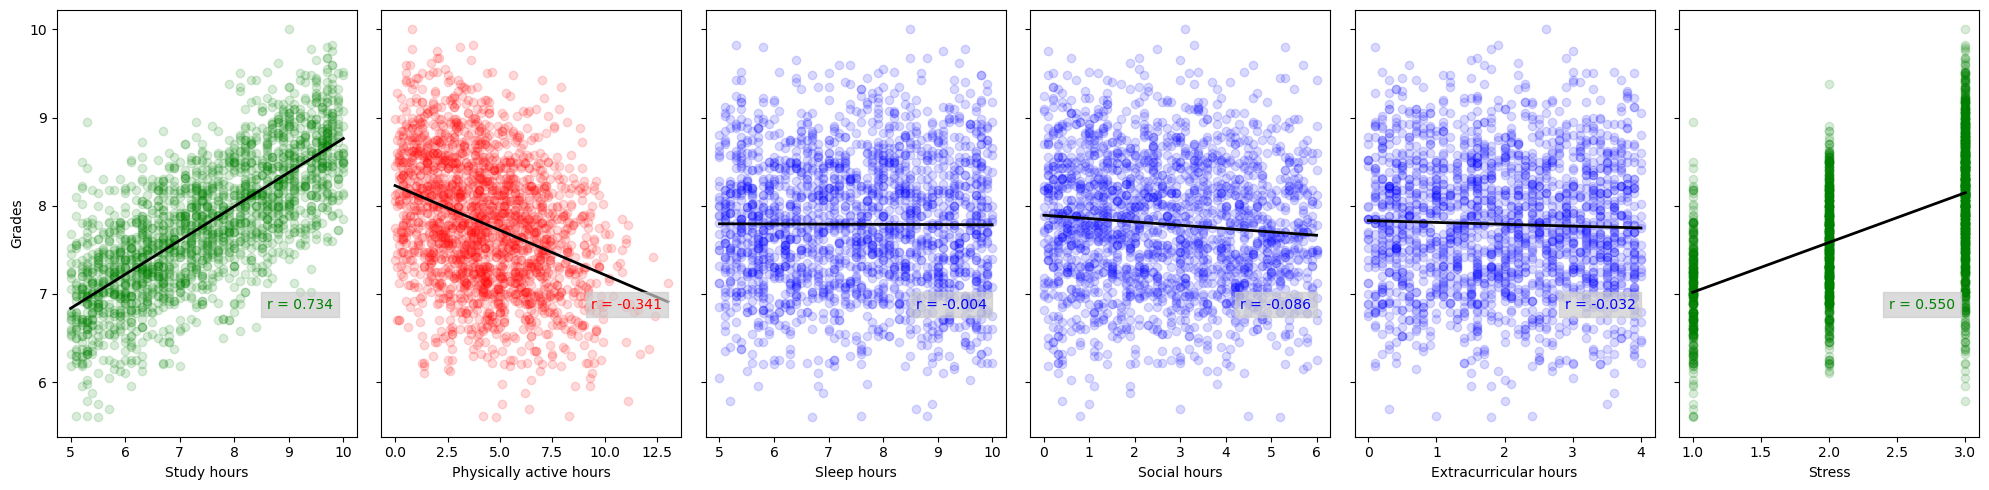

In [2]:
plot_descriptive()

Simple regression reveals three statistically significant predictors of grades: Study Hours (Positive), Physical Activity (Negative), and Stress Level (Positive). Other factors like sleep and social hours show negligible simple effects.

That studying more hours yields higher grades, is unsuprising. The other two results are more captivating. Does stress cause higher grades? And does being active mean lower grades?

Obviously, the first problem with this conclusion is that finding a correlation says nothing about causation. But the discovered relationships are nevertherless interesting.

An intuitive (but perhaps naive) interpretation could be the following:
* "Doing more sports correlates with higher grades because people that play sport tend do be dumber and therefore focus on sports instead."
* "Stress causes a student to focus on test day, resulting in better grades."

(Maybe skip the breathing excercises before your next  exam)

Now, these claims are both very bold. We should test them.


# 1) Relationship between physical activity and grades

A plausible alternative hypothesis for jocks being dumb would be the following:
"People that put a lot of hours into their sport may lose out on study time."

This would mean that activity hours would only affect your grade if you gave up study hours to do sports. That gives us a great H1:
"Physical Activity has no significant impact on Grades when controlling for Study Hours."

Let's control for study hours then! We will do linear regression seperatly for students with a high amount of study hours (more then 8 hours), those with an avarage amount (between 6 and 8 hours) and those that study few hours (less then 6).

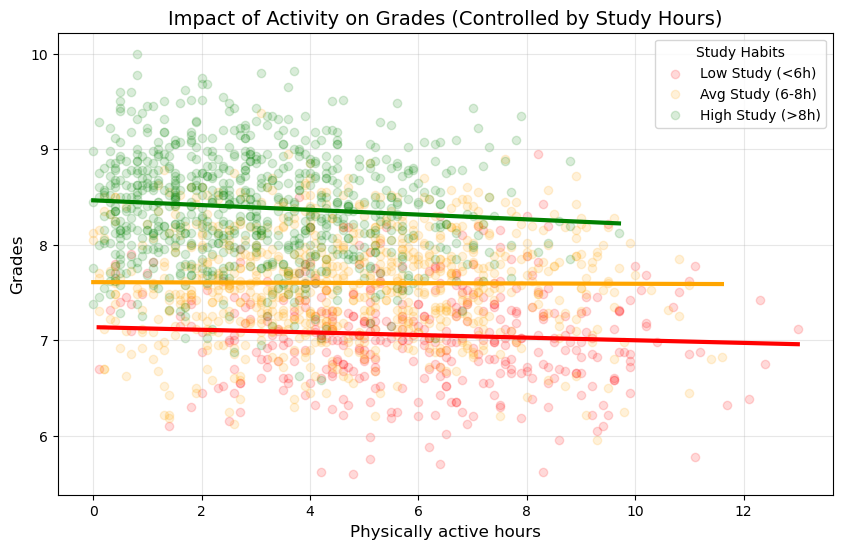

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_regression_line(ax, x, y, **kwargs):
    a,b   = np.polyfit(x, y, deg=1)
    x0,x1 = min(x), max(x)
    y0,y1 = a*x0 + b, a*x1 + b
    ax.plot([x0,x1], [y0,y1], **kwargs)
    

df['study_bin'] = pd.cut(df['studyhours'], 
                         bins=[0, 6, 8, 12], 
                         labels=['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)'])
bin_colors = {'Low Study (<6h)': 'red', 'Avg Study (6-8h)': 'orange', 'High Study (>8h)': 'green'}


fig, ax = plt.subplots(figsize=(10, 6))
for bin_name, color in bin_colors.items():
    subset = df[df['study_bin'] == bin_name]
    ax.scatter(subset['activityhours'], subset['grades'], alpha=0.15, color=color, label=bin_name)
    plot_regression_line(ax, subset['activityhours'], subset['grades'], color=color, ls='-', lw=3)

ax.set_title('Impact of Activity on Grades (Controlled by Study Hours)', fontsize=14)
ax.set_xlabel('Physically active hours', fontsize=12)
ax.set_ylabel('Grades', fontsize=12)
ax.legend(title='Study Habits')
ax.grid(True, alpha=0.3)

plt.show()

Let's calculate these slopes, and let's mark them if they are statistically significant.
Let's also put in next to our original regression plot for comparison.

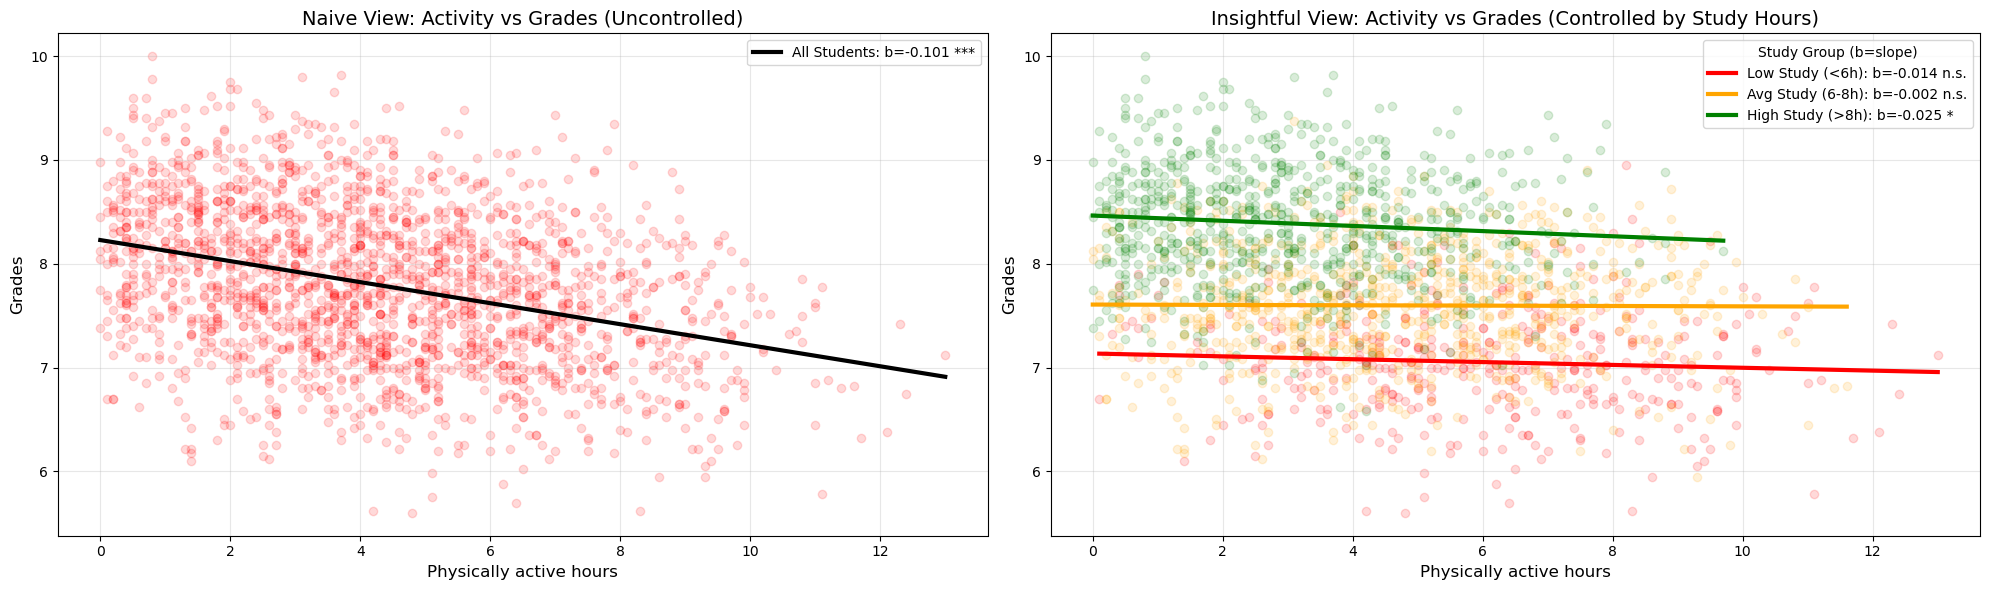

In [4]:
df['study_bin'] = pd.cut(df['studyhours'], 
                         bins=[0, 6, 8, 12], 
                         labels=['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)'])

bin_colors = {'Low Study (<6h)': 'red', 'Avg Study (6-8h)': 'orange', 'High Study (>8h)': 'green'}

def get_sig_stars(p_value):
    if p_value < 0.001: return "***"
    if p_value < 0.01:  return "**"
    if p_value < 0.05:  return "*"
    return "n.s."

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

slope, intercept, r, p, err = stats.linregress(df['activityhours'], df['grades'])
stars = get_sig_stars(p)
naive_label = f"All Students: b={slope:.3f} {stars}"

axes[0].scatter(df['activityhours'], df['grades'], alpha=0.15, color='red')
plot_regression_line(axes[0], df['activityhours'], df['grades'], color='black', ls='-', lw=3, label=naive_label)

axes[0].set_title("Naive View: Activity vs Grades (Uncontrolled)", fontsize=14)
axes[0].set_xlabel("Physically active hours", fontsize=12)
axes[0].set_ylabel("Grades", fontsize=12)
axes[0].legend(loc='upper right', frameon=True)
axes[0].grid(True, alpha=0.3)

for bin_name, color in bin_colors.items():
    subset = df[df['study_bin'] == bin_name]
    
    slope, intercept, r, p, err = stats.linregress(subset['activityhours'], subset['grades'])
    stars = get_sig_stars(p)
    stats_label = f"{bin_name}: b={slope:.3f} {stars}"
    
    axes[1].scatter(subset['activityhours'], subset['grades'], alpha=0.15, color=color)
    plot_regression_line(axes[1], subset['activityhours'], subset['grades'], color=color, ls='-', lw=3, label=stats_label)

axes[1].set_title("Insightful View: Activity vs Grades (Controlled by Study Hours)", fontsize=14)
axes[1].set_xlabel("Physically active hours", fontsize=12)
axes[1].set_ylabel("Grades", fontsize=12)
axes[1].legend(title="Study Group (b=slope)", loc='upper right', frameon=True)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Result:

We clearly see that the slopes flattened out. For the Low an Average study hours group, there is no longer a significant correlation/slope between active hours and grades (as long as you don't sacrifice study time for sports. For the highest grade, we still get a significant effect. But since the slope is so much lower when controlling for study hours, it's clear that even for this group most of the effect of active hours on grades are just due to lost study hours.

This proves how important it is to do insightfull analysis instead of just naivly interperting your results.

# 2) Relationship between stress and grades

The positive relationship between stress and grades is especially interesting. Let's try and analyze this in the same way. Since stress isn't a numeric variable tough, a T-test makes more sense here.

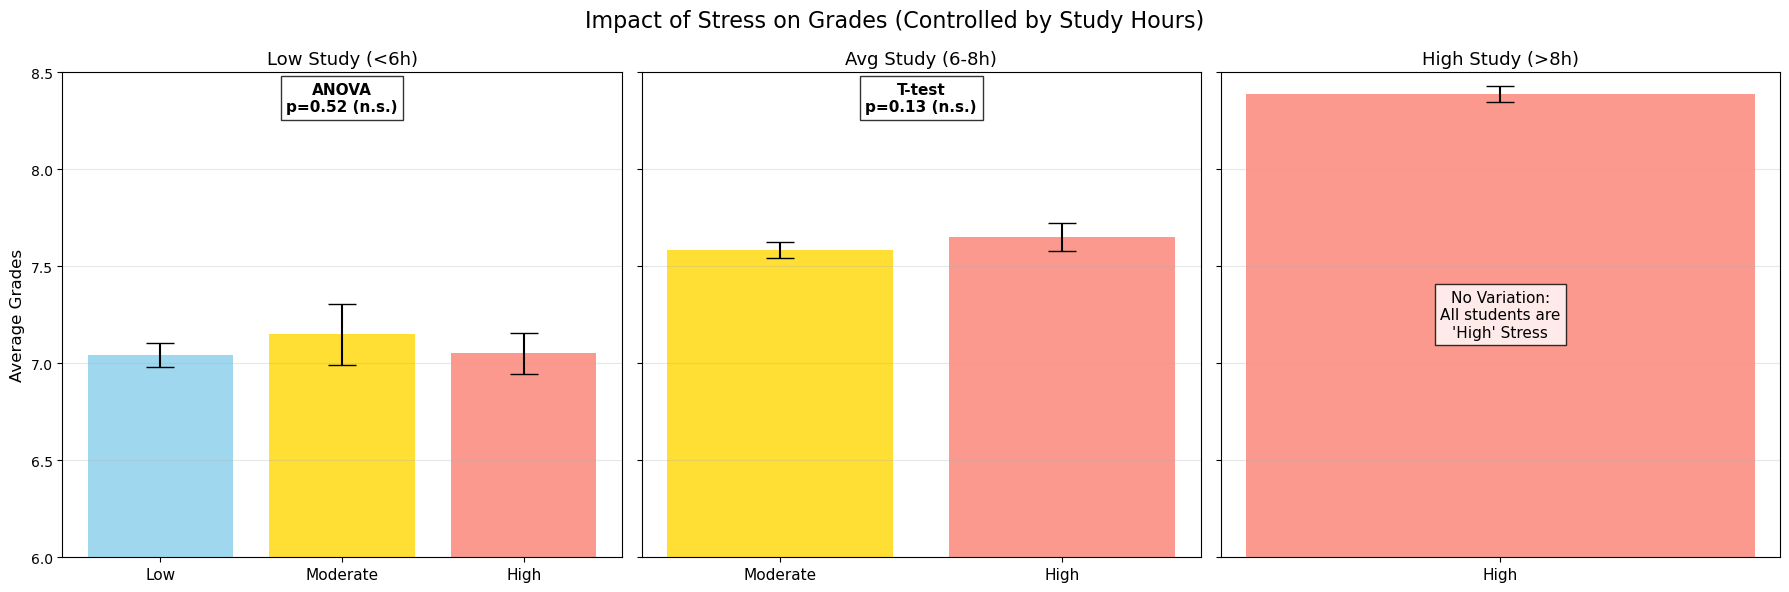

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# --- NECESSARY SETUP (FIXED) ---
# 1. Reload DataFrame
df = pd.read_csv('lifestylestudents.csv')

# 2. Map necessary columns
df['grades'] = df['Grades']
df['studyhours'] = df['Study_Hours_Per_Day']

# 3. Create Study Bins
df['study_bin'] = pd.cut(df['studyhours'], 
                         bins=[0, 6, 8, 12], 
                         labels=['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
study_groups = ['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)']
colors_map = {'Low': 'skyblue', 'Moderate': 'gold', 'High': 'salmon'}

def get_sig_text(p_val):
    if p_val < 0.001: return "***"
    if p_val < 0.01: return "**"
    if p_val < 0.05: return "*"
    return "n.s."

for i, group_name in enumerate(study_groups):
    ax = axes[i]
    subset = df[df['study_bin'] == group_name]
    
    present_data = []
    present_labels = []
    present_means = []
    present_cis = []  
    present_colors = []
    
    for stress_level in ['Low', 'Moderate', 'High']:
        # FIX: Using 'Stress_Level' (from CSV) instead of 'stress'
        data = subset[subset['Stress_Level'] == stress_level]['grades'].dropna() 
        
        if len(data) > 0:
            present_data.append(data)
            present_labels.append(stress_level)
            present_means.append(data.mean())
            ci = 1.96 * data.std() / np.sqrt(len(data)) if len(data) > 1 else 0
            present_cis.append(ci)
            present_colors.append(colors_map[stress_level])
            
    # Plotting
    if len(present_data) > 0:
        x_pos = range(len(present_data))
        ax.bar(x_pos, present_means, yerr=present_cis, color=present_colors, capsize=10, alpha=0.8)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(present_labels, fontsize=11)
        ax.set_title(f"{group_name}", fontsize=13)
        ax.grid(axis='y', alpha=0.3)
        
        # --- STATISTICAL TEST LOGIC ---
        if len(present_data) > 1:
            if len(present_data) == 2:
                # T-Test
                t, p = stats.ttest_ind(present_data[0], present_data[1], equal_var=False)
                test_label = "T-test"
            else:
                # ANOVA 
                f, p = stats.f_oneway(*present_data)
                test_label = "ANOVA"
                
            sig_txt = get_sig_text(p)
            ax.text(0.5, 0.92, f"{test_label}\np={p:.2f} ({sig_txt})", 
                            transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold',
                            bbox=dict(facecolor='white', alpha=0.8))
        else:
            # If only 1 group exists (High Study)
            ax.text(0.5, 0.5, "No Variation:\nAll students are\n'High' Stress", 
                            transform=ax.transAxes, ha='center', va='center', fontsize=11,
                            bbox=dict(facecolor='white', alpha=0.8))

axes[0].set_ylabel("Average Grades", fontsize=12)
axes[0].set_ylim(6.0, 8.5) # Consistent Y-limit
plt.suptitle("Impact of Stress on Grades (Controlled by Study Hours)", fontsize=16)
plt.tight_layout()
plt.show()

## Result:
We see that the "stress advantage" disappears. For both the Low and Average study groups, there is no significant difference in grades between relaxed and stressed students (p > 0.05). This proves that if you put in the same amount of work, "stressing out" gives you zero extra performance points.For the High Study group, we see they are exclusively high-stress, confirming that stress is just a side-effect of hard work, not the cause of success. Since the grade advantage of stress vanishes when controlling for study hours, it’s clear that the correlation we saw earlier was spurious: it wasn't stress driving the grades, it was the study hours behind it.

Let's put our new insighfull figures together to use in main.ipynb

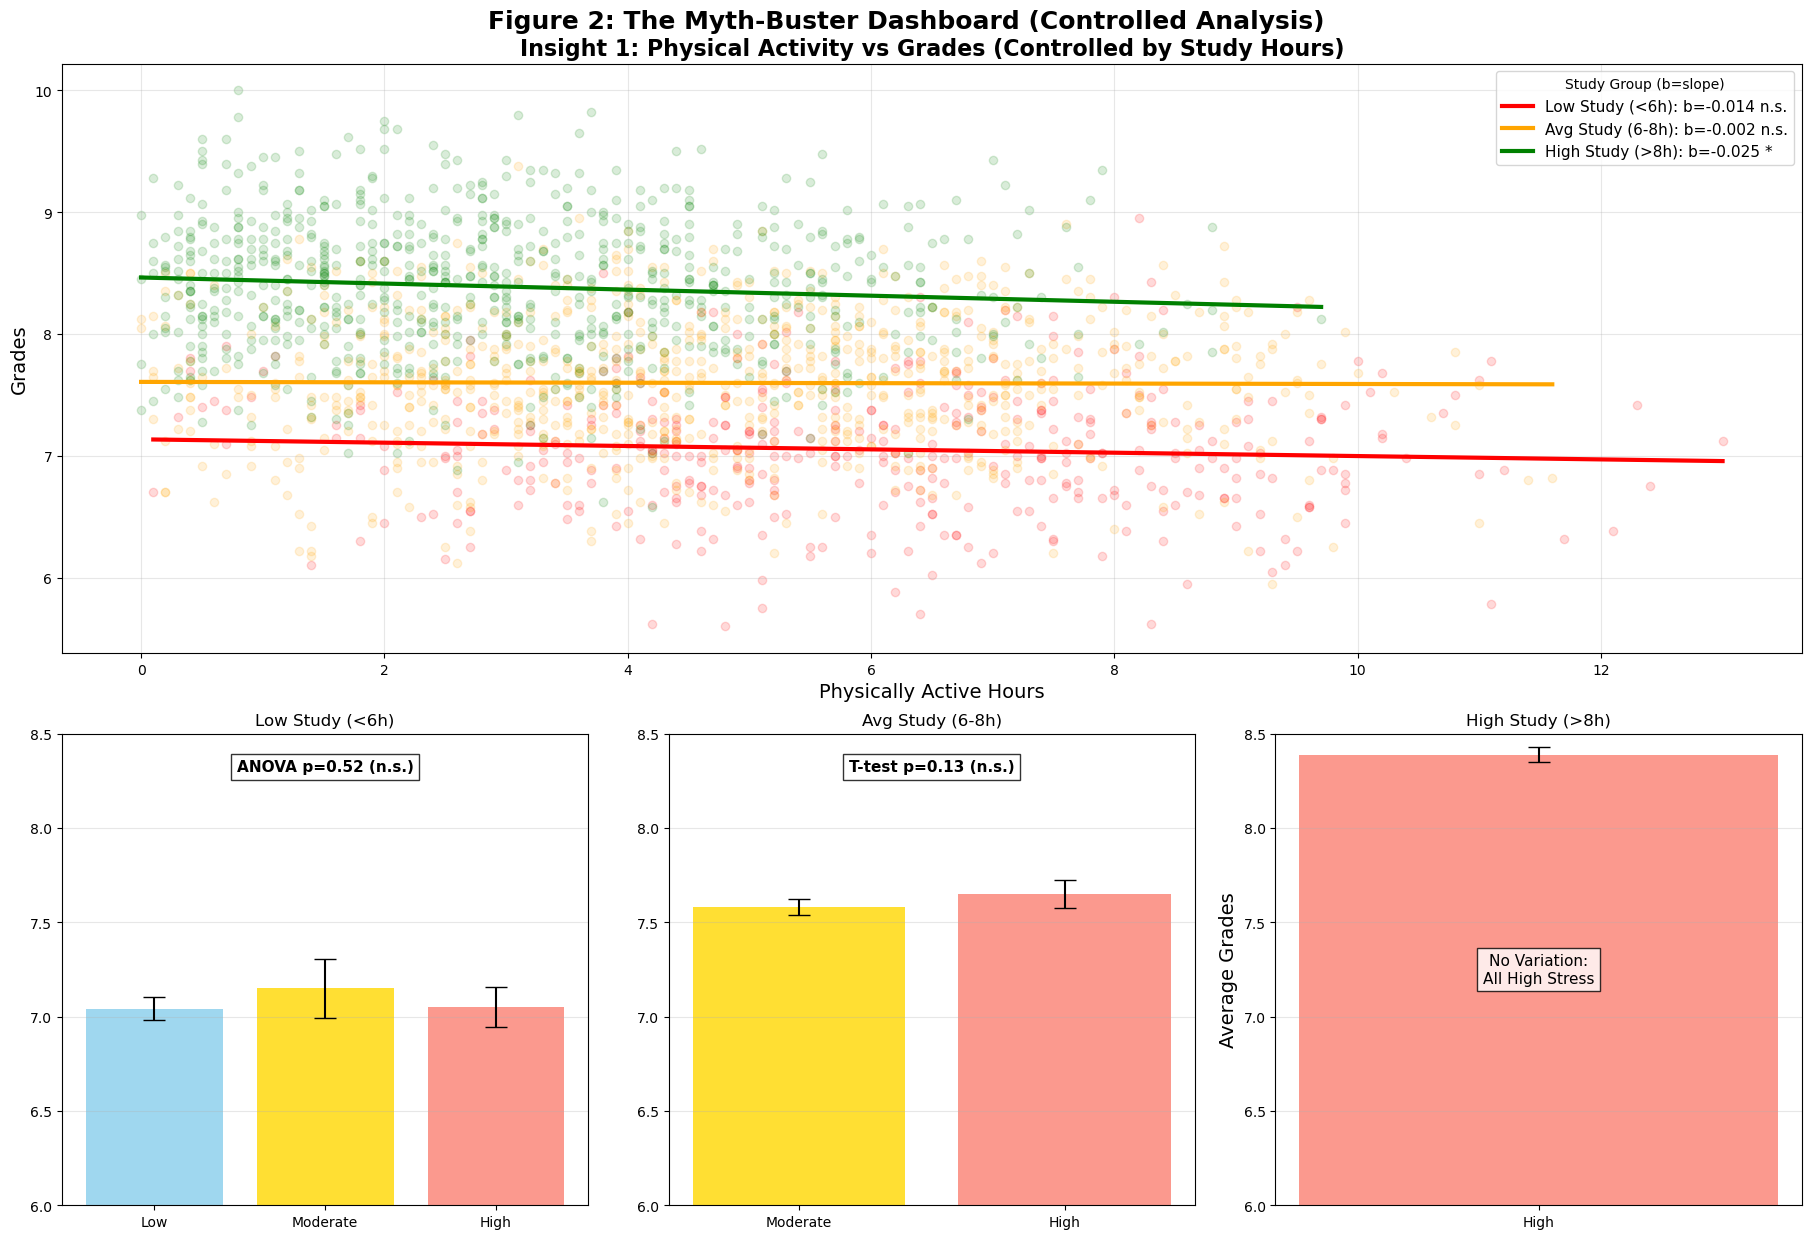

In [8]:



def plot_regression_line(ax, x, y, **kwargs):
    """Plots a linear regression line on the given axes."""
    a,b   = np.polyfit(x, y, deg=1)
    x0,x1 = min(x), max(x)
    y0,y1 = a*x0 + b, a*x1 + b
    ax.plot([x0,x1], [y0,y1], **kwargs)

def get_sig_text(p_val):
    """Determines significance asterisks based on p-value."""
    if p_val < 0.001: return "***"
    if p_val < 0.01: return "**"
    if p_val < 0.05: return "*"
    return "n.s."

def plot_hypothesistesting():
  
    
    df['grades'] = df['Grades']
    df['activityhours'] = df['Physical_Activity_Hours_Per_Day']
    df['studyhours'] = df['Study_Hours_Per_Day']
    df['stress_num'] = df['Stress_Level'].map({'Low': 1, 'Moderate': 2, 'High': 3}) 

 
    df['study_bin'] = pd.cut(df['studyhours'], 
                             bins=[0, 6, 8, 12], 

    bin_colors = {'Low Study (<6h)': 'red', 'Avg Study (6-8h)': 'orange', 'High Study (>8h)': 'green'}
    stress_colors = {'Low': 'skyblue', 'Moderate': 'gold', 'High': 'salmon'}


    fig = plt.figure(figsize=(18, 12), layout='constrained') 
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.8])


    ax_act = fig.add_subplot(gs[0, :]) 

    for bin_name, color in bin_colors.items():
        subset = df[df['study_bin'] == bin_name].copy()
        
      
        slope, intercept, r, p, err = stats.linregress(subset['activityhours'], subset['grades'])
        stars = get_sig_text(p)
        stats_label = f"{bin_name}: b={slope:.3f} {stars}"
        
      
        ax_act.scatter(subset['activityhours'], subset['grades'], alpha=0.15, color=color)
        plot_regression_line(ax_act, subset['activityhours'], subset['grades'], 
                             color=color, ls='-', lw=3, label=stats_label)

    ax_act.set_title("Insight 1: Physical Activity vs Grades (Controlled by Study Hours)", fontsize=16, fontweight='bold')
    ax_act.set_xlabel("Physically Active Hours", fontsize=14)
    ax_act.set_ylabel("Grades", fontsize=14)
    ax_act.legend(title="Study Group (b=slope)", loc='upper right', frameon=True, fontsize=11)
    ax_act.grid(True, alpha=0.3)


    
    study_groups = ['Low Study (<6h)', 'Avg Study (6-8h)', 'High Study (>8h)']

    for i, group_name in enumerate(study_groups):
        ax = fig.add_subplot(gs[1, i]) 
        subset = df[df['study_bin'] == group_name]
        
       
        present_data = []
        present_labels = []
        present_means = []
        present_cis = []
        
        for stress_level in ['Low', 'Moderate', 'High']:
            data = subset[subset['Stress_Level'] == stress_level]['grades'].dropna()
            if len(data) > 0:
                present_data.append(data)
                present_labels.append(stress_level)
                present_means.append(data.mean())
                ci = 1.96 * data.std() / np.sqrt(len(data)) if len(data) > 1 else 0
                present_cis.append(ci)
            
     
        if len(present_data) > 0:
            x_pos = range(len(present_data))
            colors = [stress_colors[label] for label in present_labels]

            ax.bar(x_pos, present_means, yerr=present_cis, color=colors, capsize=8, alpha=0.8)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(present_labels, fontsize=10)
            ax.set_title(f"{group_name}", fontsize=12)
            ax.set_ylim(6.0, 8.5) 
            ax.grid(axis='y', alpha=0.3)
            
            # --- T-Test/ANOVA Logic ---
            if len(present_data) > 1:
                if len(present_data) == 2:
                    t, p = stats.ttest_ind(present_data[0], present_data[1], equal_var=False)
                    test_label = "T-test"
                else:
                    f, p = stats.f_oneway(*present_data)
                    test_label = "ANOVA"
                
                sig = get_sig_text(p)
                ax.text(0.5, 0.92, f"{test_label} p={p:.2f} ({sig})", 
                        transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8))
            else:
                ax.text(0.5, 0.5, "No Variation:\nAll High Stress", 
                        transform=ax.transAxes, ha='center', va='center', fontsize=11,
                        bbox=dict(facecolor='white', alpha=0.8))

    fig.axes[3].set_ylabel("Average Grades", fontsize=14)
    plt.suptitle("Figure 2: The Myth-Buster Dashboard (Controlled Analysis)", y=1.02, fontsize=18, fontweight='bold')

plot_hypothesistesting()